# OneStop Paper Analyses

This notebook contains the code for reproducing the analyses in the dataset paper.

Before running the notebook make sure you have

1. Have the python environment configured, by following the instructions in the [documentation](https://lacclab.github.io/OneStop-Eye-Movements/preprocessing_analyses.html) 
2.  the data by running `
    python download_data_files.py --extract --mode onestop-full  
    `


In [2]:
import ast
from datasets import load_dataset
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
import sys
from utils import utils

In [52]:
BASE_PATH = Path("../data/OneStop/onestop-full")
METADATA_PATH = Path("../data/OneStop/metadata")
METADATA_PATH.mkdir(parents=True, exist_ok=True)
QUESTIONNAIRE_PATH = METADATA_PATH / "questionnaire.json"
SESSION_SUMMARY_PATH = METADATA_PATH / "session_summary.csv"

IA_P_PATH = Path(BASE_PATH, "ia_Paragraph.csv")
IA_Q_PATH = Path(BASE_PATH, "ia_Questions.csv")
IA_A_PATH = Path(BASE_PATH, "ia_Answers.csv")
IA_T_PATH = Path(BASE_PATH, "ia_Title.csv")
IA_QA_PATH = Path(BASE_PATH, "ia_QA.csv")
IA_Q_preview_PATH = Path(BASE_PATH, "ia_Question_preview.csv")

In [4]:
fig_save_path = Path("figures")
fig_save_path.mkdir(exist_ok=True)

In [5]:
# Load the OneStopQA dataset
onestop_qa: pd.DataFrame = load_dataset(
    "onestop_qa", split="train", trust_remote_code=True
).to_pandas() # type: ignore

In [53]:
# Download the session summary and questionnaire data
!wget -O ../data/OneStop/metadata/session_summary.csv https://osf.io/download/yvu5w
!wget -O ../data/OneStop/metadata/questionnaire.json https://osf.io/download/a765t

--2025-10-09 14:31:13--  https://osf.io/download/yvu5w
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 308 PERMANENT REDIRECT
Location: https://osf.io/download/yvu5w/ [following]
--2025-10-09 14:31:14--  https://osf.io/download/yvu5w/
Reusing existing connection to osf.io:443.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/jbd24/providers/osfstorage/676590797f64c40edac55a6e [following]
--2025-10-09 14:31:14--  https://files.osf.io/v1/resources/jbd24/providers/osfstorage/676590797f64c40edac55a6e
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/cos-osf-prod-files-us-east1/4cb5b66067bd55bd7d297a5092fc47a579e2058b30cb92f891accb2810b33dda?response-content-disposition=attachment

In [54]:
questionnaire_df = pd.DataFrame(utils.load_json(QUESTIONNAIRE_PATH))
session_summary = utils.load_df(SESSION_SUMMARY_PATH)

In [8]:
IA_P = utils.load_df(IA_P_PATH)
IA_Q = utils.load_df(IA_Q_PATH)
IA_A = utils.load_df(IA_A_PATH)
IA_Q_preview = utils.load_df(IA_Q_preview_PATH)
IA_T = utils.load_df(IA_T_PATH)
IA_QA = utils.load_df(IA_QA_PATH)

# Textual Materials

In [9]:
# Number of unique articles
unique_articles = onestop_qa.drop_duplicates(subset=["title"])
print(f"Total number of unique articles: {len(unique_articles)}")

Total number of unique articles: 30


In [10]:
# Number of unique paragraphs
unique_paragraphs = onestop_qa.drop_duplicates(subset=["paragraph"]).query("level!=1")
number_of_paragraphs = len(unique_paragraphs) / 2
print(f"Total number of unique paragraphs: {number_of_paragraphs}")

Total number of unique paragraphs: 162.0


In [11]:
# Calculate mean number of words per level
n_words = (
    onestop_qa.drop_duplicates(subset=["paragraph"])
    .query("level!=1")
    .groupby("level")["paragraph"]
    .apply(lambda x: x.str.split().str.len().sum())
)

print("Mean number of words per level:")
print(f"Advanced (level 0): {round(n_words[0], 1)}")
print(f"Elementary (level 2): {round(n_words[2], 1)}")

Mean number of words per level:
Advanced (level 0): 19425
Elementary (level 2): 15737


In [12]:
# Advanced word tokens
adv_qa = unique_paragraphs[unique_paragraphs["level"] == 0]
adv_qa_words = [
    word
    for paragraph in utils.get_number_of_tokens(adv_qa, "paragraph")
    for word in paragraph
]

adv_sentences = [
    sen
    for paragraph in utils.get_number_of_tokens(adv_qa, "paragraph")
    for sen in paragraph
    if "." in sen
]

print(f"OneStopQA Advanced Words Count: {len(adv_qa_words)}")
print(
    f"mean paragraph length (words): {round(len(adv_qa_words) / number_of_paragraphs, 1)}"
)
print(
    f"mean sentence length (words): {round(len(adv_qa_words) / len(adv_sentences), 1)}"
)

OneStopQA Advanced Words Count: 19425
mean paragraph length (words): 119.9
mean sentence length (words): 20.8


In [13]:
# Elementary word tokens
ele_qa = unique_paragraphs[unique_paragraphs["level"] == 2]
ele_qa_words = [
    word
    for paragraph in utils.get_number_of_tokens(ele_qa, "paragraph")
    for word in paragraph
]

ele_sentences = [
    sen
    for paragraph in utils.get_number_of_tokens(ele_qa, "paragraph")
    for sen in paragraph
    if "." in sen
]
print(f"OneStopQA Elementary Words Count: {len(ele_qa_words)}")
print(
    f"mean paragraph length (words): {round(len(ele_qa_words) / number_of_paragraphs, 1)}"
)
print(
    f"mean sentence length (words): {round(len(ele_qa_words) / len(ele_sentences), 1)}"
)

OneStopQA Elementary Words Count: 15737
mean paragraph length (words): 97.1
mean sentence length (words): 17.0


In [14]:
res_0 = utils.analyze_text_series(unique_paragraphs.query("level==0")["paragraph"])
res_2 = utils.analyze_text_series(unique_paragraphs.query("level==2")["paragraph"])
print(
    f"Mean sentences per paragraph in Advanced: {round(res_0.sentence_count.mean(), 2)}"
)
print(
    f"Mean sentences per paragraph in Elementary: {round(res_2.sentence_count.mean(), 2)}"
)

Mean sentences per paragraph in Advanced: 5.77
Mean sentences per paragraph in Elementary: 5.75


In [15]:
# Calculate total words and sentences for level 0
total_words_0 = res_0["word_count"].sum()
total_sentences_0 = res_0["sentence_count"].sum()
avg_words_per_sentence_0 = round(total_words_0 / total_sentences_0, 1)

# Calculate total words and sentences for level 2
total_words_2 = res_2["word_count"].sum()
total_sentences_2 = res_2["sentence_count"].sum()
avg_words_per_sentence_2 = round(total_words_2 / total_sentences_2, 1)

print(f"Level 0 average words per sentence: {avg_words_per_sentence_0}")
print(f"Level 2 average words per sentence: {avg_words_per_sentence_2}")

Level 0 average words per sentence: 20.8
Level 2 average words per sentence: 16.9


In [16]:
# Number of unique questions
onsqa_q = onestop_qa.drop_duplicates(subset=["paragraph_index", "question"])
onsqa_q_words = onsqa_q["question"]

print(f"Number of unique questions in OneStopQA: {len(onsqa_q)}")
print(
    f"Average length of questions in OneStopQA: {round(utils.get_average_length(onsqa_q_words), 1)}"
)

Number of unique questions in OneStopQA: 486
Average length of questions in OneStopQA: 9.9


In [17]:
# number of unique answers
onestop_qa["answers_tuple"] = onestop_qa["answers"].apply(tuple)
onsqa_a = onestop_qa.drop_duplicates(subset=["question", "answers_tuple"])
onsqa_a = onsqa_a.drop(columns=["answers_tuple"])
answers_df = pd.DataFrame(onsqa_a["answers"].tolist(), columns=["a", "b", "c", "d"])
onsqa_a = onsqa_a.reset_index(drop=True)
onsqa_a = pd.concat([onsqa_a, answers_df], axis=1)
a = onsqa_a["a"].tolist()
b = onsqa_a["b"].tolist()
c = onsqa_a["c"].tolist()
d = onsqa_a["d"].tolist()
unique_answers = a + b + c + d

print(f"Total Unique Answers: {len(onsqa_a)}")
print(f"Mean Length of 'a': {round(utils.get_average_length(a), 1)}")
print(f"Mean Length of 'b': {round(utils.get_average_length(b), 1)}")
print(f"Mean Length of 'c': {round(utils.get_average_length(c), 1)}")
print(f"Mean Length of 'd': {round(utils.get_average_length(d), 1)}")
print(
    f"Mean Length of All Unique Answers: {round(utils.get_average_length(unique_answers), 1)}"
)

Total Unique Answers: 486
Mean Length of 'a': 7.1
Mean Length of 'b': 7.5
Mean Length of 'c': 7.9
Mean Length of 'd': 6.8
Mean Length of All Unique Answers: 7.3


In [18]:
# mean length of the critical span (a_span)
onsqa_a_span = unique_paragraphs["a_span"]
total_words_a = []
for a in onsqa_a_span:
    words = a[1] - a[0] + 1
    total_words_a.append(words)
mean_a = sum(total_words_a) / len(total_words_a)
print(f"Mean Length of Critical Span (a_span): {round(mean_a, 1)}")
# mean length of the distractor span (d_span)
onsqa_d_span = unique_paragraphs["d_span"]
total_words_d = []
for d in onsqa_d_span:
    words = d[1] - d[0] + 1
    total_words_d.append(words)
mean_d = sum(total_words_d) / len(total_words_d)
print(f"Mean Length of Distractor Span (d_span): {round(mean_d, 1)}")

Mean Length of Critical Span (a_span): 31.6
Mean Length of Distractor Span (d_span): 12.9


# Participants

In [19]:
# participants recruited from:
data_collection_sites = session_summary["data_collection_site"].value_counts()
print(data_collection_sites)

data_collection_site
MIT         303
Technion     57
Name: count, dtype: int64


In [20]:
metadata = session_summary.merge(
    questionnaire_df, left_on="participant_id", right_on="Participant ID"
)
metadata_gathering = metadata[metadata["question_preview"] == False]
print(
    f"Mean AoA of Gathering participants: {metadata_gathering['English AoA'].mean().round(1)}"
)

Mean AoA of Gathering participants: 0.5


In [21]:
uni_affiliation = sum(metadata_gathering["University Affiliation"] == "yes")
print(f"Number of participants with university affiliation: {uni_affiliation}")
print(f"In percent: {round(uni_affiliation / len(metadata_gathering) * 100, 1)}%")

Number of participants with university affiliation: 138
In percent: 76.7%


In [22]:
print(f"Mean Age of Gathering participants: {metadata_gathering.Age.mean().round(1)}")

Mean Age of Gathering participants: 23.4


# Key Statistics

In [23]:
# Calculate the lengths
p = len(IA_P)
q = len(IA_Q)
a = len(IA_A)
qa = len(IA_QA)
q_pre = len(IA_Q_preview)
t = len(IA_T)
total = p + q + a + t + q_pre

# Consolidated print statement
print(
    f"Number of tokens in IA reports:\nparagraphs - {p}\nquestions - {q}\nquestions and answers - {qa}\nquestions preview - {q_pre}\ntitles - {t}\ntotal words - {total}"
)

Number of tokens in IA reports:
paragraphs - 2632159
questions - 242208
questions and answers - 1190732
questions preview - 121110
titles - 38798
total words - 3982709


## Participants

In [24]:
print(f"Total number of participants: {len(session_summary)}")

Total number of participants: 360


In [25]:
# Eye conditions

eye_cond = questionnaire_df.loc[
    questionnaire_df["Eye Conditions"] == "Yes", ["Eye Condition Details"]
].reset_index(drop=True)

# Apply normalization and get counts
conditions = utils.normalize_eye_conditions(eye_cond, "Eye Condition Details")
conditions["merged"] = (
    conditions["Condition1"].fillna("") + " " + conditions["Condition2"].fillna("")
)
condition_counts = conditions["Normalized Condition"].value_counts()

# Display results
print("Eye Condition Counts:")
print(condition_counts)

Eye Condition Counts:
Normalized Condition
[Astigmatism]                                                                                22
[Lens-Corrected Myopia]                                                                      15
[Astigmatism, Lens-Corrected Myopia]                                                          3
[Amblyopia]                                                                                   1
[Pseudotumor Cerebri (cured)]                                                                 1
[Other: One eye does not see as well as the other, but cannot be corrected with glasses.]     1
[Glasses]                                                                                     1
Name: count, dtype: int64


In [26]:
# gender
gender = questionnaire_df["Gender"]
labels, counts = np.unique(gender, return_counts=True)
print(
    f"{labels[0]} - {counts[0]}, {labels[1]} - {counts[1]}, {labels[2]} - {counts[2]}"
)

female - 238, male - 117, other - 5


In [27]:
print(
    f"Age mean - {round(questionnaire_df['Age'].mean(), ndigits=1)}, \
    Age std - {round(questionnaire_df['Age'].std(), 1)}"
)

Age mean - 22.8,     Age std - 5.8


In [28]:
# Balanced Bilinguals
counter = 0
for languages in questionnaire_df["Languages"]:
    if isinstance(languages, list):
        for lang in languages:
            if lang.get("Language Proficiency") == "native":
                counter += 1
print(f"Number of balanced bilinguals: {counter}")

# Number of Additional Languages
par_dict = {}
participants_additional_languages = questionnaire_df["Languages"]
par_languages = []
speak = []
for participant_add_lang in participants_additional_languages:
    if isinstance(participant_add_lang, list):
        for l in participant_add_lang:
            par_languages.append(l.get("Language"))
        speak.append(len(participant_add_lang))
    else:
        participant_add_lang = ""
        speak.append(len(participant_add_lang))
lang, counts = np.unique(par_languages, return_counts=True)
language = dict(zip(lang, counts))
num_of_l, c = np.unique(speak, return_counts=True)
num_of_languages = dict(zip(num_of_l, c))
plus_5 = [min(p_5, 5) for p_5 in speak]
num_of_l_5, c_5 = np.unique(plus_5, return_counts=True)
num_of_lang_plus_5 = dict(zip(num_of_l_5, c_5))

Number of balanced bilinguals: 29


In [29]:
# The mean English Age of Acquisition
print(
    f"Mean age of acquisition (AoA) - {round(np.mean(questionnaire_df['English AoA']), 1)}"
)

Mean age of acquisition (AoA) - 0.4


In [30]:
# participants university affiliation
uni_affiliation = sum(questionnaire_df["University Affiliation"] == "yes")
print(f"Number of participants with university affiliation: {uni_affiliation}")

uni_institutions = questionnaire_df["University Institution"].dropna()
institution_mapping = {
    "mit": "MIT",
    "Technion": "Technion",
}
uni_institutions_grouped = uni_institutions.apply(
    lambda x: institution_mapping.get(x, "Other")
)

institutions_labels, institutions_counts = np.unique(
    uni_institutions_grouped, return_counts=True
)
print("University Institutions and their counts:")
for i_label, i_count in zip(institutions_labels, institutions_counts):
    print(f"{i_label}: {i_count}")

uni_roles = questionnaire_df["University Role"].dropna()
roles_mapping = {
    "undergrad": "Undergrad",
    "grad": "Grad",
    "faculty": "Faculty",
    "admin": "Admin",
}
uni_roles_grouped = uni_roles.apply(lambda x: roles_mapping.get(x, "Other"))
role_labels, role_counts = np.unique(uni_roles_grouped, return_counts=True)
print("University Roles and their counts:")
for r_label, r_count in zip(role_labels, role_counts):
    print(f"{r_label}: {r_count}")

Number of participants with university affiliation: 289
University Institutions and their counts:
MIT: 207
Other: 63
Technion: 19
University Roles and their counts:
Admin: 4
Faculty: 13
Grad: 39
Other: 8
Undergrad: 225


/var/folders/fz/wnp3jl2n1z1gsgdq_g6_34ww0000gn/T/ipykernel_83485/1914534755.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set(xticklabels=education_labels)
/var/folders/fz/wnp3jl2n1z1gsgdq_g6_34ww0000gn/T/ipykernel_83485/1914534755.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set(xticklabels=add_lang_labels)


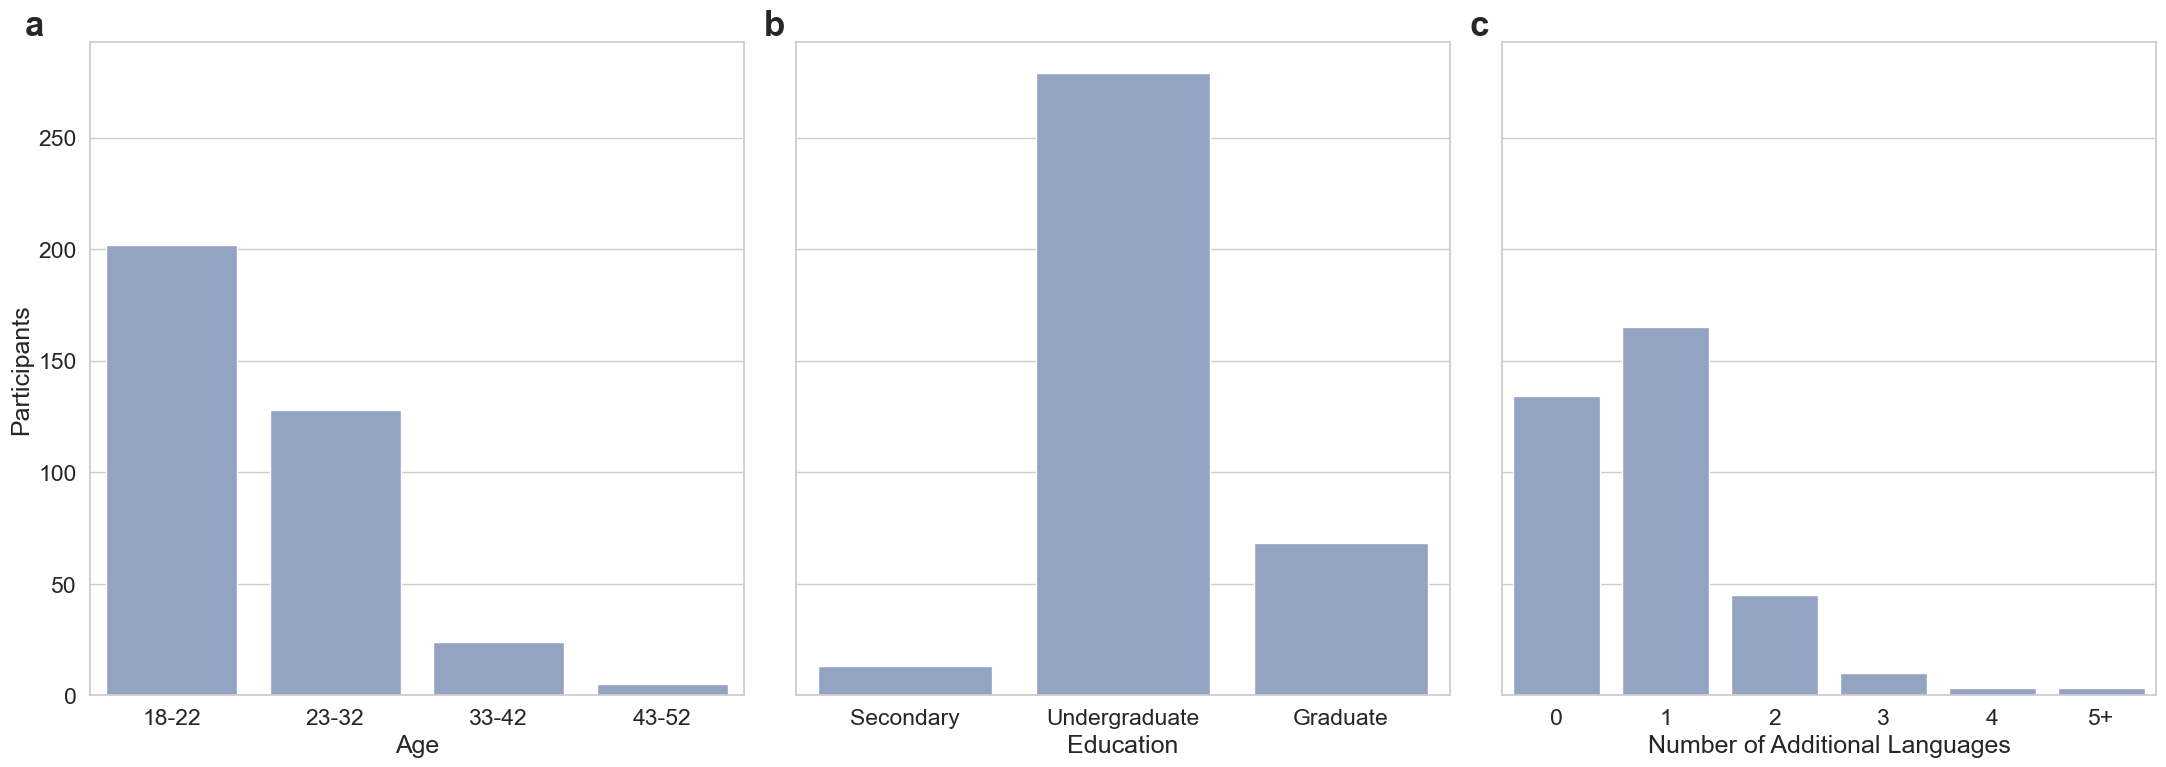

In [55]:
# Create Figure 3: Demographics
sns.set_context("paper", font_scale=2)
sns.set_theme(font_scale=1.5, style="whitegrid")
fig_colors = "#8da0cb"  # "#a1c9f4"
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 8), sharey="row")
sns.set_style("whitegrid")

# Plot 1: Countplot for Age
age_bins = [18, 22, 32, 42, 52]
age_labels = ["18-22", "23-32", "33-42", "43-52"]
data = questionnaire_df.copy()
data["age_category"] = pd.cut(
    data["Age"], bins=age_bins, labels=age_labels, right=False
)
sns.countplot(
    data=data, x="age_category", color=fig_colors, ax=axes[0], order=age_labels
)
axes[0].set(ylabel="Participants")
axes[0].set(xlabel="Age")

# Plot 2: Countplot for Level of Education
education_order = ["secondary", "college", "postgrad"]
education_labels = ["Secondary", "Undergraduate", "Graduate"]
sns.countplot(
    data=data, x="Education Level", color=fig_colors, ax=axes[1], order=education_order
)
axes[1].set(xticklabels=education_labels)
axes[1].set(ylabel="")
axes[1].set(xlabel="Education")

# Plot 3: Barplot for Number of Additional Languages
add_lang_labels = ["0", "1", "2", "3", "4", "5+"]
axes[2] = sns.barplot(
    x=list(num_of_lang_plus_5.keys()),
    y=list(num_of_lang_plus_5.values()),
    color=fig_colors,
    ax=axes[2],
)
axes[2].set(ylabel="")
axes[2].set(xlabel="Number of Additional Languages")
axes[2].set(xticklabels=add_lang_labels)

# Add labels (a, b, c) to each subplot
axes[0].text(
    -0.1,
    1.05,
    "a",
    transform=axes[0].transAxes,
    fontsize=25,
    fontweight="bold",
    va="top",
)
axes[1].text(
    -0.05,
    1.05,
    "b",
    transform=axes[1].transAxes,
    fontsize=25,
    fontweight="bold",
    va="top",
)
axes[2].text(
    -0.05,
    1.05,
    "c",
    transform=axes[2].transAxes,
    fontsize=25,
    fontweight="bold",
    va="top",
)

# Adjust layout
plt.tight_layout()

# Save the plot as pdf
plt.savefig(fig_save_path / "figure3-demographics.pdf")

# Show the plot
plt.show()

## Experiment Duration

In [32]:
print(
    f"mean duration (in minutes) - {round(np.mean(session_summary['session_duration']), 1)}"
)
print(
    f"mean total duration (in minutes) - {round(np.mean(session_summary['total_session_duration']), 1)}"
)
print(
    f"total duration of eye movements recordings (in hours) - {round(np.sum(session_summary['session_duration']) / 60, 1)}"
)

mean duration (in minutes) - 44.3
mean total duration (in minutes) - 55.7
total duration of eye movements recordings (in hours) - 265.8


In [33]:
hunting = session_summary[session_summary["question_preview"] == True]
gathering = session_summary[session_summary["question_preview"] == False]
h_session_duration = hunting["session_duration"]
g_session_duration = gathering["session_duration"]
print(f"mean hunting duration - {round(np.mean(h_session_duration), 1)}")
print(f"mean gathering duration - {round(np.mean(g_session_duration), 1)}")
h_total_session_duration = hunting["total_session_duration"]
g_total_session_duration = gathering["total_session_duration"]
print(f"total mean hunting duration - {round(np.mean(h_total_session_duration), 1)}")
print(f"total mean gathering duration - {round(np.mean(g_total_session_duration), 1)}")

mean hunting duration - 43.3
mean gathering duration - 45.3
total mean hunting duration - 54.3
total mean gathering duration - 57.1


In [34]:
# paragraph duration
ia_p = IA_P.drop_duplicates(
    subset=["participant_id", "article_batch", "article_id", "paragraph_id", "repeated_reading_trial"]
)
ia_h_duration = ia_p[ia_p["question_preview"] == True]
ia_g_duration = ia_p[ia_p["question_preview"] == False]
ia_p = ia_p.groupby("participant_id").sum()
ia_h_duration = ia_h_duration.groupby("participant_id").sum()
ia_g_duration = ia_g_duration.groupby("participant_id").sum()

print(f"mean p - {round((ia_p['PARAGRAPH_RT'] / 1000 / 60).mean(), 1)}")
print(f"p hunting - {round((ia_h_duration['PARAGRAPH_RT'] / 1000 / 60).mean(), 1)}")
print(f"p gathering - {round((ia_g_duration['PARAGRAPH_RT'] / 1000 / 60).mean(), 1)}")
# q duration
print(f"mean q - {round((ia_p['QUESTION_RT'] / 1000 / 60).mean(), 1)}")
print(f"q hunting - {round((ia_h_duration['QUESTION_RT'] / 1000 / 60).mean(), 1)}")
print(f"q gathering - {round((ia_g_duration['QUESTION_RT'] / 1000 / 60).mean(), 1)}")
# a duration
print(f"mean a - {round((ia_p['CONFIRM_FINAL_ANSWER_RT'] / 1000 / 60).mean(), 1)}")
print(
    f"a hunting - {round((ia_h_duration['CONFIRM_FINAL_ANSWER_RT'] / 1000 / 60).mean(), 1)}"
)
print(
    f"a gathering - {round((ia_g_duration['CONFIRM_FINAL_ANSWER_RT'] / 1000 / 60).mean(), 1)}"
)
# q&a duration
print(
    f"mean qa - {round((ia_p['QUESTION_RT'] / 1000 / 60).mean() + (ia_p['CONFIRM_FINAL_ANSWER_RT'] / 1000 / 60).mean(), 1)}"
)
print(
    f"qa hunting - {round((ia_h_duration['QUESTION_RT'] / 1000 / 60).mean() + (ia_h_duration['CONFIRM_FINAL_ANSWER_RT'] / 1000 / 60).mean(), 1)}"
)
print(
    f"qa gathering - {round((ia_g_duration['QUESTION_RT'] / 1000 / 60).mean() + (ia_g_duration['CONFIRM_FINAL_ANSWER_RT'] / 1000 / 60).mean(), 1)}"
)
# q_preview duration
print(
    f"q preview - {round((ia_h_duration['PREVIEW_QUESTION_RT'] / 1000 / 60).mean(), 1)}"
)

mean p - 26.0
p hunting - 23.1
p gathering - 28.9
mean q - 2.6
q hunting - 2.5
q gathering - 2.7
mean a - 7.6
a hunting - 7.1
a gathering - 8.0
mean qa - 10.2
qa hunting - 9.6
qa gathering - 10.8
q preview - 3.5


## Reading Comprehension Performance

In [35]:
# reading comprehension accuracy Hunting
comprehension_score = session_summary.groupby(["question_preview"])[
    "comprehension_score-regular_trials"
].mean()
comprehension_hunting = comprehension_score[True]
# reading comprehension accuracy Gathering
comprehension_gathering = comprehension_score[False]

# reading comprehension accuracy re-reading Hunting
reread_comprehension_score = session_summary.groupby(["question_preview"])[
    "comprehension_score-repeated_reading"
].mean()
reread_comprehension_hunting = reread_comprehension_score[True]
# reading comprehension accuracy re-reading Gathering
reread_comprehension_gathering = reread_comprehension_score[False]


print(
    f"Reading Comprehension Accuracy - Hunting (without reread): {comprehension_hunting.round(1)}"
)
print(
    f"Reading Comprehension Accuracy - Gathering (without reread): {comprehension_gathering.round(1)}"
)
print(
    f"Reading Comprehension Accuracy - Hunting (with reread): {reread_comprehension_hunting.round(1)}"
)
print(
    f"Reading Comprehension Accuracy - Gathering (with reread): {reread_comprehension_gathering.round(1)}"
)

Reading Comprehension Accuracy - Hunting (without reread): 86.9
Reading Comprehension Accuracy - Gathering (without reread): 81.2
Reading Comprehension Accuracy - Hunting (with reread): 90.6
Reading Comprehension Accuracy - Gathering (with reread): 84.2


# Data quality

## Calibration quality

In [36]:
# mean number of calibration sessions during an experiment
session_interruptions = session_summary["recalibration_count"]
print(f"Mean number of recalibrations: {round(np.mean(session_interruptions), 1)}")

# mean number of calibration attempts per calibration session
mean_calibrations_per_session = sum(session_summary["total_recalibrations"]) / sum(
    session_summary["recalibration_count"]
)
print(
    f"Mean number of calibrations per-recalibration session: {round(mean_calibrations_per_session, 1)}"
)

Mean number of recalibrations: 6.7
Mean number of calibrations per-recalibration session: 1.3


In [37]:
# Percent validation error over 0.3
validation_error = pd.read_csv(  "utils/validation_error.csv")
over_03 = validation_error[["num_over_03", "total_trials"]].sum()

percentage_over_03 = round(over_03["num_over_03"] / over_03["total_trials"] * 100, 1)
percentage_avg_error_over_03 = round(
    (validation_error["avg_avg_val_error"] > 0.3).sum() / 360 * 100, 1
)

print(f"Percentage of Trials Over 0.3 Error: {percentage_over_03}%")
print(f"Percentage of Validation Errors Over 0.3: {percentage_avg_error_over_03}%")

Percentage of Trials Over 0.3 Error: 15.5%
Percentage of Validation Errors Over 0.3: 8.9%


## Accuracy of fixation assignments to lines

In [38]:
final_df = pd.read_csv("line_assignment_annotations/fixation_annotations.csv")

# Parse string representations of lists into actual lists
list_columns = [
    'incorrect_line_annotator1',
    'incorrect_line_annotator2',
    'other_annotator1',
    'other_annotator2'
]

for col in list_columns:
    final_df[col] = final_df[col].apply(ast.literal_eval)
final_df.head()

,file_name,num_lines,number_of_fixations,participant_id,trial_index,other_annotator1,other_annotator2,incorrect_line_annotator1,incorrect_line_annotator2
0,10_056_l2_324_40.pdf,10,56,l2_324,40,"[5, 9, 12, 18, 19, 20, 21, 26, 31, 32, 33, 41,...","[5, 9, 12, 18, 19, 26, 31, 33, 40, 41, 46, 49,...",[36],[]
1,10_056_l48_535_44.pdf,10,56,l48_535,44,"[6, 11, 12, 14, 15, 16, 22, 27, 31, 38, 39, 44...","[6, 11, 12, 16, 17, 22, 27, 31, 38, 39, 44, 50...","[36, 42, 43]","[36, 42, 43]"
2,10_057_l36_280_56.pdf,10,57,l36_280,56,"[8, 9, 12, 16, 22, 26, 27, 29, 36, 42, 46, 47,...","[8, 9, 12, 13, 16, 22, 26, 27, 32, 36, 37, 42,...","[7, 20, 41]","[7, 20, 41]"
3,10_059_l52_477_34.pdf,10,59,l52_477,34,"[5, 10, 12, 14, 18, 24, 25, 30, 31, 36, 37, 42...","[5, 10, 12, 14, 18, 24, 25, 30, 31, 36, 37, 42...","[6, 11]","[6, 11]"
4,10_060_l48_140_33.pdf,10,60,l48_140,33,"[8, 16, 17, 23, 24, 29, 35, 39, 43, 49, 50, 56]","[8, 16, 17, 23, 24, 29, 35, 39, 43, 49, 50, 56]",[11],[11]


In [39]:
# Combine incorrect_line and other_line from both annotators using union
final_df['incorrect_line'] = [
    sorted(list(set(final_df.iloc[i]['incorrect_line_annotator1']) | set(final_df.iloc[i]['incorrect_line_annotator2'])))
    for i in range(len(final_df))
]

final_df['other'] = [
    sorted(list(set(final_df.iloc[i]['other_annotator1']) | set(final_df.iloc[i]['other_annotator2'])))
    for i in range(len(final_df))
]

# Calculate mistake count, other count, and error rate
final_df['mistake_count'] = final_df['incorrect_line'].apply(len)
final_df['other_count'] = final_df['other'].apply(len)
final_df['error_rate'] = final_df['mistake_count'] / (final_df['number_of_fixations'])

In [40]:
# Create combined binary lists for overall annotation (mistake=1, unknown=2, correct=0)
annotator1_overall = []
annotator2_overall = []

for i in range(len(final_df)):
    row = final_df.iloc[i]
    
    for line_idx in range(row['number_of_fixations']):
        # Annotator1's annotation
        if line_idx in row['incorrect_line_annotator1']:
            annotator1_overall.append(1)
        elif line_idx in row['other_annotator1']:
            annotator1_overall.append(2)
        else:
            annotator1_overall.append(0)
        
        # Annotator2's annotation
        if line_idx in row['incorrect_line_annotator2']:
            annotator2_overall.append(1)
        elif line_idx in row['other_annotator2']:
            annotator2_overall.append(2)
        else:
            annotator2_overall.append(0)

# Compute Cohen's Kappa for overall agreement
overall_agreement = cohen_kappa_score(annotator1_overall, annotator2_overall)

print(f"Total fixations annotated: {len(annotator1_overall)}")
print(f"Overall inter-annotator agreement (Cohen's Kappa): {overall_agreement:.3f}")
# Count occurrences of each label
a1_counts = {
    "correct": annotator1_overall.count(0),
    "mistake": annotator1_overall.count(1),
    "other": annotator1_overall.count(2)
}

a2_counts = {
    "correct": annotator2_overall.count(0),
    "mistake": annotator2_overall.count(1),
    "other": annotator2_overall.count(2)
}

print("\nAnnotator 1 label distribution:")
for label, count in a1_counts.items():
    print(f"  {label}: {count} ({count/len(annotator1_overall):.1%})")

print("\nAnnotator 2 label distribution:")
for label, count in a2_counts.items():
    print(f"  {label}: {count} ({count/len(annotator2_overall):.1%})")

# Calculate overall distribution based on the combined incorrect_line and unknown_line fields
total_fixations = sum(final_df['number_of_fixations'])
total_mistakes = sum(final_df['mistake_count'])
total_other = sum(final_df['other_count'])
total_correct = total_fixations - total_mistakes - total_other

print("\nOverall distribution based on final (combined) annotations:")
print(f"  correct: {total_correct} ({total_correct/total_fixations:.1%})")
print(f"  mistake: {total_mistakes} ({total_mistakes/total_fixations:.1%})")
print(f"  other: {total_other} ({total_other/total_fixations:.1%})")

# print average of % fixations marked as correct and as other between annotators
avg_correct_rate = (a1_counts['correct']/len(annotator1_overall) + a2_counts['correct']/len(annotator2_overall)) / 2
avg_other_rate = (a1_counts['other']/len(annotator1_overall) + a2_counts['other']/len(annotator2_overall)) / 2
print(f"\nAverage correct rate between annotators: {avg_correct_rate:.1%}")
print(f"Average other rate between annotators: {avg_other_rate:.1%}")

Total fixations annotated: 1296
Overall inter-annotator agreement (Cohen's Kappa): 0.945

Annotator 1 label distribution:
  correct: 929 (71.7%)
  mistake: 50 (3.9%)
  other: 317 (24.5%)

Annotator 2 label distribution:
  correct: 949 (73.2%)
  mistake: 48 (3.7%)
  other: 299 (23.1%)

Overall distribution based on final (combined) annotations:
  correct: 924 (71.3%)
  mistake: 50 (3.9%)
  other: 322 (24.8%)

Average correct rate between annotators: 72.5%
Average other rate between annotators: 23.8%


# Figure 4

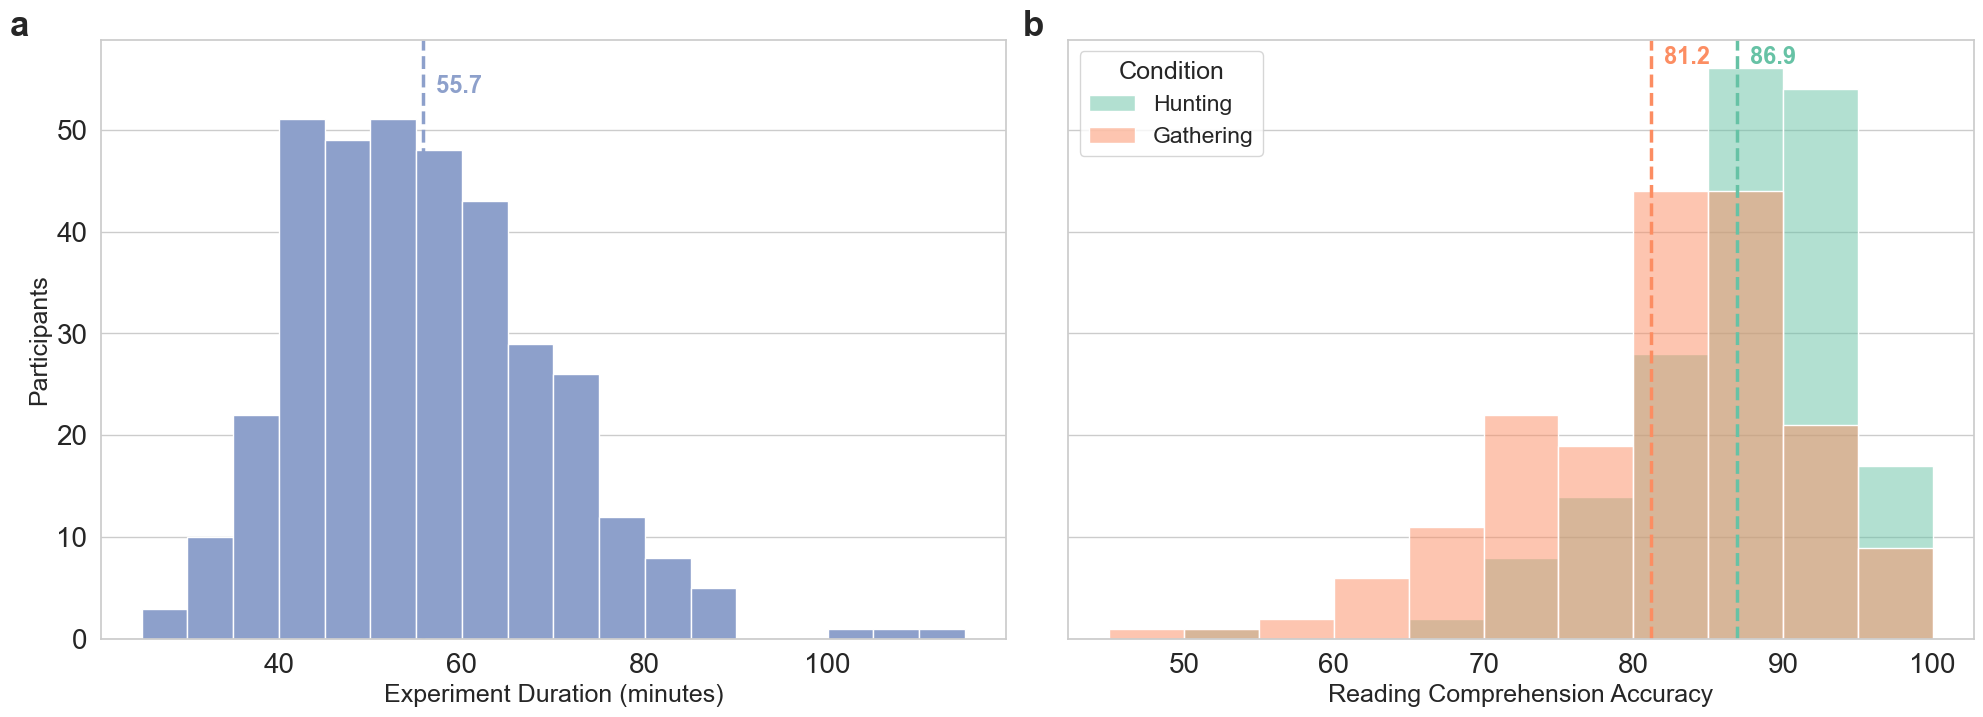

In [56]:
sns.set_context("paper", font_scale=2)
sns.set_theme(font_scale=1.5, style="whitegrid")
# Create Figure 2
fig_colors = "#8da0cb"
colors = ["#66c2a5", "#fc8d62"]
color_dict = {
    True: colors[0],
    False: colors[1],
}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7.5), sharey=True)

data = session_summary.copy()

# Plot 3: Experiment Duration
axes[0] = sns.histplot(
    data,
    x="total_session_duration",
    color=fig_colors,
    ax=axes[0],
    binrange=(25, 115),
    binwidth=5,
    alpha=1.0
)
axes[0].axvline(
    data["total_session_duration"].mean(), color=fig_colors, ls="--", lw=2.5
)
axes[0].set(ylabel="Participants")
axes[0].set(xlabel="Experiment Duration (minutes)")

axes[0].text(
    data["total_session_duration"].mean(),
    axes[0].get_ylim()[1] * 1,
    f"  {data['total_session_duration'].mean():.1f}",
    color=fig_colors,
    ha="left",
    fontsize=17,
    fontweight="bold",
)

# Plot 4: Reading Comprehension Score
condition_labels = [
    "Hunting",
    "Gathering",
]

axes[1] = sns.histplot(
    data=data,
    x="comprehension_score-regular_trials",
    palette=color_dict,
    ax=axes[1],
    hue="question_preview",
    multiple="layer",
    binrange=(45, 100),
    binwidth=5,
)

axes[1].legend(
    labels=condition_labels,
    title="Condition",
    loc="upper left",
)
axes[1].set(xlabel="Reading Comprehension Accuracy")
axes[1].set(ylabel="")
axes[1].axvline(
    comprehension_gathering,
    color=colors[1],
    ls="--",
    lw=2.5,
)

axes[1].text(
    comprehension_gathering,
    axes[1].get_ylim()[1] * 0.96,
    f"  {comprehension_gathering:.1f}",
    color=colors[1],
    ha="left",
    fontsize=17,
    fontweight="bold",
)

axes[1].axvline(
    comprehension_hunting,
    color=colors[0],
    ls="--",
    lw=2.5,
)

axes[1].text(
    comprehension_hunting,
    axes[1].get_ylim()[1] * 0.96,
    f"  {comprehension_hunting:.1f}",
    color=colors[0],
    ha="left",
    fontsize=17,
    fontweight="bold",
)

# Add labels (a, b) to each subplot
axes[0].text(
    -0.1,
    1.05,
    "a",
    transform=axes[0].transAxes,
    fontsize=25,
    fontweight="bold",
    va="top",
)
axes[1].text(
    -0.05,
    1.05,
    "b",
    transform=axes[1].transAxes,
    fontsize=25,
    fontweight="bold",
    va="top",
)

# increase font size
for ax in axes.flat:
    ax.tick_params(axis="both", which="major", labelsize=20),
    ax.grid(axis='y', which='major', linestyle='-', linewidth=1),
    ax.grid(False, axis='x') 

# Set facecolor for the figure
fig.set_facecolor("white")

# Adjust layout
plt.tight_layout()

# Save the plot as pdf
plt.savefig(fig_save_path / "figure4-exp_stats.pdf")

# Show the plot
plt.show()


## Figure 5 - Calibrations

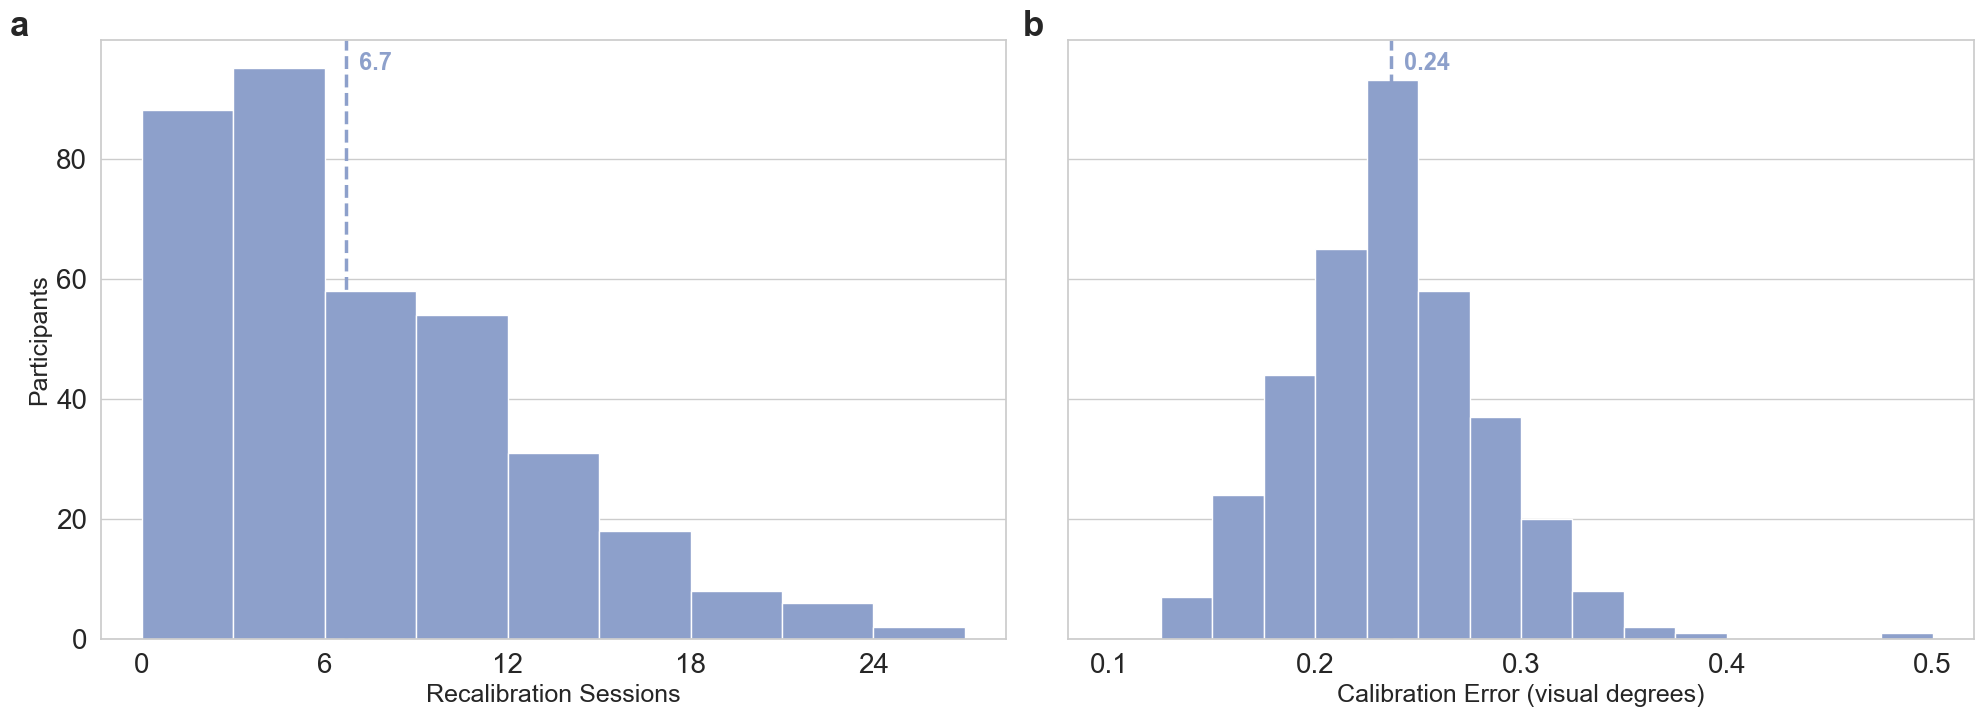

In [44]:
sns.set_context("paper", font_scale=2)
sns.set_theme(font_scale=1.5, style="whitegrid")
# Create Figure 2
fig_colors = "#8da0cb"
colors = ["#66c2a5", "#fc8d62"]
color_dict = {
    True: colors[0],
    False: colors[1],
}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7.5), sharey="row")

data = session_summary.copy()
# Plot 1: Number of Recalibrations
axes[0] = sns.histplot(
    data,
    x="recalibration_count",
    color=fig_colors,
    ax=axes[0],
    binrange=(0, 27),
    binwidth=3,
    alpha=1.0
)
axes[0].set(ylabel="Participants")
axes[0].set(xlabel="Recalibration Sessions")
axes[0].axvline(session_interruptions.mean(), color=fig_colors, ls="--", lw=2.5)
axes[0].set_xticks(np.arange(0, 28, 6))

axes[0].text(
    session_interruptions.mean(),
    axes[0].get_ylim()[1] * 0.95,
    f"  {session_interruptions.mean():.1f}",
    color=fig_colors,
    ha="left",
    fontsize=17,
    fontweight="bold",
)

# Plot 2: Validations
axes[1] = sns.histplot(
    data,
    x="mean_validation_error",
    color=fig_colors,
    ax=axes[1],
    binrange=(0.1, 0.5),
    binwidth=0.025,
    alpha=1.0
)
axes[1].set(ylabel="")
axes[1].set(xlabel="Calibration Error (visual degrees)")
axes[1].axvline(
    data["mean_validation_error"].mean(), color=fig_colors, ls="--", lw=2.5
)
axes[1].set_xticks(np.arange(0.1, 0.51, 0.1))

axes[1].text(
    data["mean_validation_error"].mean(),
    axes[1].get_ylim()[1] * 0.95,
    f"  {data['mean_validation_error'].mean():.2f}",
    color=fig_colors,
    ha="left",
    fontsize=17,
    fontweight="bold",
)

# Add labels (a, b) to each subplot
axes[0].text(
    -0.1,
    1.05,
    "a",
    transform=axes[0].transAxes,
    fontsize=25,
    fontweight="bold",
    va="top",
)
axes[1].text(
    -0.05,
    1.05,
    "b",
    transform=axes[1].transAxes,
    fontsize=25,
    fontweight="bold",
    va="top",
)

# increase font size
for ax in axes.flat:
    ax.tick_params(axis="both", which="major", labelsize=20),
    ax.grid(axis='y', which='major', linestyle='-', linewidth=1),
    ax.grid(False, axis='x') 

fig.set_facecolor("white")
plt.tight_layout()
plt.savefig(fig_save_path / "figure5-calibration.pdf")
plt.show()


# Benchmarks for Global Eye Movement Measures


## Table 6

In [ ]:
sys.path.append(str(Path().resolve().parent))

from onestop_paper_analyses.utils.other_datasets_utils import (
    get_outcome_vars,
    load_and_process_dataset,
    rounding_dict,
)

from onestop_paper_analyses.utils.mixed_effects_wrapper.calc_means_main import (
    calc_mm_means_for_all_outcomes,
)
from onestop_paper_analyses.utils.mixed_effects_wrapper.constants import (
    outcome_name_mapping,
)
from onestop_paper_analyses.utils.mixed_effects_wrapper.julia_linear_mm import (
    jl,
    run_linear_mm,
)
from onestop_paper_analyses.utils.mixed_effects_wrapper.utils import exclude_IAs

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [ ]:
# To run this code you need to download the CELER dataset, GECO dataset and SB-SAT dataset. 
# See other_datasets/README.md for more details.

# dataset_options = ["onestop", "celer", "geco", "sbsat"]
dataset = "onestop"  # Change this to "sbsat", "geco", or "onestop" as needed

In [ ]:
ia_rep, fix_rep, ia_rep_fixated_only = load_and_process_dataset(dataset=dataset)
pos_outcomes, fix_rep_outcomes, non_pos_outcomes = get_outcome_vars(dataset=dataset)

In [ ]:
if dataset == "onestop":
    evs = ["has_preview", "reread"]
elif dataset == "celer":
    evs = ["L1"]
else:
    evs = []

if dataset == "onestop":
    re_columns = ["participant_id", "unique_paragraph_id"]
elif dataset == "sbsat":
    re_columns = ["RECORDING_SESSION_LABEL", "page_name"]
elif dataset == "geco":
    re_columns = ["PP_NR"]
elif dataset == "celer":
    re_columns = ["list"]

In [ ]:
ia_means_df = calc_mm_means_for_all_outcomes(
    df=ia_rep_fixated_only,  # type: ignore
    explanatory_variable_list=evs,
    re_columns=re_columns,
    outcomes=pos_outcomes,
    mean_mode="subset_mean",
)

if dataset != "sbsat":
    means_skip_rate = calc_mm_means_for_all_outcomes(
        df=ia_rep,
        explanatory_variable_list=evs,
        re_columns=re_columns,
        outcomes=non_pos_outcomes,
        mean_mode="subset_mean",
    )

if type(fix_rep) is pd.DataFrame:
    fix_means_df = calc_mm_means_for_all_outcomes(
        df=fix_rep,
        explanatory_variable_list=evs,
        re_columns=re_columns,
        outcomes=fix_rep_outcomes,
        mean_mode="subset_mean",
    )

outcome_variable: IA_FIRST_FIXATION_DURATION
df_m shape before dropping nan: (472151, 62)
df_m shape after dropping nan: (472151, 62)
u_vals: ['']


100%|██████████| 1/1 [00:05<00:00,  5.73s/it]


outcome_variable: IA_FIRST_RUN_DWELL_TIME
df_m shape before dropping nan: (472151, 62)
df_m shape after dropping nan: (472151, 62)
u_vals: ['']


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


outcome_variable: IA_FIRST_PASS_GAZE_DURATION
df_m shape before dropping nan: (472151, 62)
df_m shape after dropping nan: (374375, 62)
u_vals: ['']


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


outcome_variable: IA_DWELL_TIME
df_m shape before dropping nan: (472151, 62)
df_m shape after dropping nan: (472151, 62)
u_vals: ['']


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


outcome_variable: IA_FIXATION_COUNT
df_m shape before dropping nan: (774015, 61)
df_m shape after dropping nan: (774015, 61)
u_vals: ['']


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


outcome_variable: IA_ZERO_TF
df_m shape before dropping nan: (774015, 61)
df_m shape after dropping nan: (774015, 61)
u_vals: ['']


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


outcome_variable: IA_SKIP
df_m shape before dropping nan: (774015, 61)
df_m shape after dropping nan: (774015, 61)
u_vals: ['']


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


In [ ]:
if dataset in ["onestop", "celer"]:
    means_df = pd.concat([ia_means_df, fix_means_df, means_skip_rate], axis=0)
elif dataset == "sbsat":
    means_df = pd.concat([ia_means_df, fix_means_df], axis=0)
elif dataset == "geco":
    means_df = pd.concat([ia_means_df, means_skip_rate], axis=0)

In [ ]:
means_df_styled = means_df.copy()


# round values if 'mean' and '2se' according to rounding dict by outcome_variable value
def means_df_to_table(means_df):
    for outcome_variable in pos_outcomes + fix_rep_outcomes + non_pos_outcomes:
        means_df.loc[means_df["outcome_variable"] == outcome_variable, "mean"] = (
            means_df.loc[
                means_df["outcome_variable"] == outcome_variable, "mean"
            ].round(rounding_dict[outcome_variable])
        )
        means_df.loc[means_df["outcome_variable"] == outcome_variable, "2se"] = (
            means_df.loc[means_df["outcome_variable"] == outcome_variable, "2se"].round(
                rounding_dict[outcome_variable]
            )
        )

    means_df["mean_sd_str"] = (
        "$"
        + means_df["mean"].astype(str)
        + r"_{\pm "
        + (means_df["2se"]).astype(str)
        + "}$"
    )

    # replace each value in 'outcome_variable' with its value in the dict outcome_name_mapping
    means_df["outcome_variable"] = means_df["outcome_variable"].map(
        outcome_name_mapping, na_action="ignore"
    )

    return means_df


means_df_styled = means_df_to_table(means_df_styled)

if dataset in ["onestop", "celer"]:
    means_df_pivot = means_df_styled.pivot(
        index="outcome_variable",
        columns=evs,
        values="mean_sd_str",
    )

    means_df_styled = means_df_pivot.loc[
        list(
            map(
                lambda x: outcome_name_mapping[x],
                pos_outcomes + non_pos_outcomes + fix_rep_outcomes,
            )
        ),
        :,
    ]

means_df_styled

,mean,p_val,2se,outcome_variable,mean_sd_str
0,211.80,1.063365e-181,14.40,First Fixation Duration,$211.8_{\pm 14.4}$
0,233.90,1.643163e-149,17.60,Gaze Duration,$233.9_{\pm 17.6}$
0,237.90,1.042739e-138,18.60,First Pass Gaze Duration,$237.9_{\pm 18.6}$
0,274.20,3.774188e-103,24.90,Total Fixation Duration,$274.2_{\pm 24.9}$
0,0.80,3.242616e-104,0.07,Fixation Count,$0.8_{\pm 0.07}$
0,0.39,1.685378e-115,0.03,Global Skip Rate (TF = 0),$0.39_{\pm 0.03}$
0,0.52,1.847560e-162,0.04,Skip Rate,$0.52_{\pm 0.04}$


## OneStop Comparisons - Information Seeking (question preview) $\times$ Repeated Reading

In [ ]:
ia_rep, fix_rep, ia_rep_fixated_only = load_and_process_dataset(dataset="onestop")
pos_outcomes, fix_rep_outcomes, non_pos_outcomes = get_outcome_vars(dataset="onestop")

FileNotFoundError: [Errno 2] No such file or directory: '/data/home/shared/onestop/processed/ia_data_enriched_360_05052024.csv'

In [ ]:
# link_dist_dict is a dict with

link_dist_dict = {
    outcome: jl.Distributions.Normal()
    for outcome in pos_outcomes + fix_rep_outcomes + non_pos_outcomes
}


link_dist_dict["IA_FIXATION_COUNT"] = jl.Distributions.Normal()  # type: ignore
link_dist_dict["IA_SKIP"] = jl.Distributions.Normal()  # type: ignore
link_dist_dict["IA_ZERO_TF"] = jl.Distributions.Normal()  # type: ignore
link_dist_dict["NEXT_SAC_AMPLITUDE"] = jl.Distributions.Normal()

In [ ]:
import time

comparisons_lists = {}

for outcome in pos_outcomes + ["IA_SKIP", "IA_ZERO_TF"] + fix_rep_outcomes:
    curr_time = time.time()

    if outcome in pos_outcomes:
        curr_df = ia_rep_fixated_only.copy()
    elif outcome in ["IA_SKIP", "IA_ZERO_TF"]:
        curr_df = ia_rep.copy()
    elif outcome in fix_rep_outcomes:
        curr_df = fix_rep.copy()

    # remove all rows where the outcome contains nan
    curr_df = curr_df.dropna(subset=[outcome])

    outcome_p_vals_lst = []
    # Inside Gathering: FR vs. RR
    for hp_val in ["Hunting", "Gathering"]:
        coefs, _ = run_linear_mm(
            df_input=curr_df.query(f"has_preview == '{hp_val}'"),
            re_cols=["participant_id", "unique_paragraph_id"],
            outcome_variable=outcome,
            link_dist=link_dist_dict[outcome],
            formula=f"{outcome} ~ reread + (1 + reread | participant_id) + (1 + reread | unique_paragraph_id)",
            print_model_res=False,
        )
        outcome_p_vals_lst.append(
            float(coefs.loc[coefs["Name"] == "reread"]["Pr(>|z|)"].values[0])  # type: ignore
        )

    curr_df["has_preview"] = curr_df["has_preview"].map({"Hunting": 1, "Gathering": 0})
    for RR_val in [0, 1]:
        coefs, _ = run_linear_mm(
            df_input=curr_df.query(f"reread == {RR_val}"),
            re_cols=["participant_id", "unique_paragraph_id"],
            outcome_variable=outcome,
            link_dist=link_dist_dict[outcome],
            formula=f"{outcome} ~ has_preview + (1 | participant_id) + (1 + has_preview | unique_paragraph_id)",
            print_model_res=False,
        )
        outcome_p_vals_lst.append(
            float(coefs.loc[coefs["Name"] == "has_preview"]["Pr(>|z|)"].values[0])  # type: ignore
        )

    comparisons_lists[outcome] = outcome_p_vals_lst
    end_time = time.time()

    print(f"Time for {outcome}: {end_time - curr_time}")

Time for IA_FIRST_FIXATION_DURATION: 9.777475357055664
Time for IA_FIRST_RUN_DWELL_TIME: 10.77896785736084
Time for IA_FIRST_PASS_GAZE_DURATION: 8.941622018814087
Time for IA_DWELL_TIME: 9.72004771232605
Time for IA_SKIP: 15.859427452087402
Time for IA_ZERO_TF: 18.362783670425415
Time for NEXT_SAC_AMPLITUDE: 13.876774072647095
Time for CURRENT_FIX_DURATION: 12.941179513931274


In [ ]:
pd.DataFrame(comparisons_lists)

,IA_FIRST_FIXATION_DURATION,IA_FIRST_RUN_DWELL_TIME,IA_FIRST_PASS_GAZE_DURATION,IA_DWELL_TIME,IA_SKIP,IA_ZERO_TF,NEXT_SAC_AMPLITUDE,CURRENT_FIX_DURATION
0,1.780807e-25,4.994712e-47,3.194146e-51,3.108847e-62,1.073549e-120,8.147545e-179,3.604977e-74,1.775915e-23
1,5.389258e-26,3.792187e-49,1.300008e-55,3.400843e-70,7.333160e-64,6.727799e-113,6.077370e-91,9.172452e-22
2,6.408005e-03,5.083444e-05,1.520236e-05,4.609489e-04,6.373326e-10,4.509028e-13,8.511741e-04,2.167473e-02
3,4.835347e-03,4.129025e-05,2.327122e-05,3.075912e-02,1.378149e-29,9.073196e-29,3.707514e-03,1.179091e-02


## All Datasets - Compare Means for All Measures

In [ ]:
dataset_names = ["onestop", "geco", "sbsat", "celer"]


def create_dataset_dict(dataset_name: str):
    ia_rep, fix_rep, ia_rep_fixated_only = load_and_process_dataset(
        dataset=dataset_name
    )
    pos_outcomes, fix_rep_outcomes, non_pos_outcomes = get_outcome_vars(
        dataset=dataset_name
    )
    return {
        "ia_rep": ia_rep,
        "fix_rep": fix_rep,
        "ia_rep_fixated_only": ia_rep_fixated_only,
        "pos_outcomes": pos_outcomes,
        "fix_rep_outcomes": fix_rep_outcomes,
        "non_pos_outcomes": non_pos_outcomes,
    }


datasets_dict = {name: create_dataset_dict(name) for name in dataset_names}

Could not convert IA_FIRST_PASS_GAZE_DURATION to numeric
Could not convert IA_FIRST_PASS_GAZE_DURATION to numeric


/data/home/meiri.yoav/OneStop-Eye-Movements/src/other_datasets_analyses/other_datasets_utils.py:161: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  fix_rep = pd.read_csv(


Could not convert IA_FIRST_PASS_GAZE_DURATION to numeric


In [ ]:
temp_item_id_col_name = "item_id"
temp_participant_id_col_name = "participant_id"


# create a dict of (dataset1_name, dataset2_name) -> (outcome_variable -> p_value)
def perform_ttest(data1, data2, outcome_key):
    test_res = stats.ttest_ind(
        data1[outcome_key],
        data2[outcome_key],
        alternative="two-sided",
        nan_policy="omit",
        equal_var=False,
    )  # make the pval a float
    pval = test_res.pvalue
    return "{:e}".format(pval)


def compare_two_datasets(dataset1_dict: dict, dataset2_dict: dict):
    outcome_types = {
        "pos_outcomes": ("ia_rep_fixated_only", "ia_rep_fixated_only"),
        "fix_rep_outcomes": ("fix_rep", "fix_rep"),
        "non_pos_outcomes": ("ia_rep", "ia_rep"),
    }

    comparison_results = []

    # Iterate through each outcome type
    for outcome_key, (data_key1, data_key2) in outcome_types.items():
        curr_dataset1 = dataset1_dict[data_key1]

        outcomes_to_compare = set(dataset1_dict[outcome_key]).intersection(
            dataset2_dict[outcome_key]
        )

        # Perform t-tests on the common outcomes
        for outcome in outcomes_to_compare:
            p_value = perform_ttest(
                dataset1_dict[data_key1], dataset2_dict[data_key2], outcome
            )
            comparison_results.append((outcome, p_value))

    return comparison_results


comparisons_dict = {}
for dataset1_name, dataset2_name in combinations(dataset_names, 2):
    comparisons_dict[(dataset1_name, dataset2_name)] = compare_two_datasets(
        datasets_dict[dataset1_name], datasets_dict[dataset2_name]
    )

/tmp/ipykernel_3138233/569167697.py:7: SmallSampleWarning: After omitting NaNs, one or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  test_res = stats.ttest_ind(


In [ ]:
# Pivot the DataFrame so that the rows become the variable names (metrics)
# Create a dataframe from the input data
data = []
for key, values in comparisons_dict.items():
    for metric, value in values:
        data.append([key[0], key[1], metric, value])

df = pd.DataFrame(data, columns=["Dataset1", "Dataset2", "Metric", "Value"])

pivot_df = df.pivot_table(
    index="Metric", columns=["Dataset1", "Dataset2"], values="Value", aggfunc="first"
)

pivot_df.columns = ["_".join(col).strip() for col in pivot_df.columns.values]

In [ ]:
pivot_df

,geco_celer,geco_sbsat,onestop_celer,onestop_geco,onestop_sbsat,sbsat_celer
Metric,,,,,,
CURRENT_FIX_DURATION,NaN,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00
IA_DWELL_TIME,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
IA_FIRST_FIXATION_DURATION,0.000000e+00,3.394039e-52,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
IA_FIRST_PASS_GAZE_DURATION,nan,nan,0.000000e+00,nan,6.974993e-103,0.000000e+00
IA_FIRST_RUN_DWELL_TIME,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
IA_FIXATION_COUNT,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN
IA_REGRESSION_OUT_FULL_COUNT,NaN,NaN,0.000000e+00,NaN,NaN,NaN
IA_SKIP,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN
IA_ZERO_TF,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN


# The Effect of Linguistic Word Properties on Reading Times


In [ ]:
dataset = "onestop"
ia_rep, fix_rep, ia_rep_fixated_only = load_and_process_dataset(dataset=dataset)
pos_outcomes, fix_rep_outcomes, non_pos_outcomes = get_outcome_vars(dataset=dataset)

Could not convert IA_FIRST_PASS_GAZE_DURATION to numeric


In [ ]:
fix_rep = fix_rep.merge(
    ia_rep[
        ["unique_paragraph_id", "IA_ID", "end_of_line", "start_of_line", "reread"]
    ].drop_duplicates(),
    on=["unique_paragraph_id", "IA_ID", "reread"],
    how="left",
)

In [ ]:
#! Exclude beginning / end of paragraph line, words with punctuations, numbers
ia_rep_fixated_only = ia_rep[ia_rep["IA_DWELL_TIME"] > 0]

ia_rep_fixated_only = exclude_IAs(ia_rep_fixated_only, remove_start_end_of_line=False)
fix_rep = exclude_IAs(fix_rep, remove_start_end_of_line=False)

In [ ]:
class config:
    def __init__(self):
        self.method = "MM_coeffs"
        self.outcome_variable = "log_IA_DWELL_TIME"
        self.explanatory_variable: str | list[str] = "reread"
        self.data_path = "metadata"

        self.fig_path = "onestop/figures"
        self.exclusion_df: bool = True
        self.model_formula: str = ""
        # self.log_transform_outcome = False
        self.z_score_w_r_t_explanatory = True
        # query is article_ind_of_first_reading >= 0
        self.df_query = ""
        self.re_columns = ["participant_id", "unique_paragraph_id"]

        self.config_name = (
            "Coeffs. " + self.outcome_variable + "_" + self.explanatory_variable
        )

In [ ]:
explanatory_var_class_names = {
    "reread": {
        0: "First reading",
        1: "Repeated Reading",
        "0": "First Reading",
        "1": "Repeated Reading",
    },
    "has_preview_reread": {
        "Gathering_1": "Gathering, RR",
        "Gathering_0": "Gathering, Not RR",
        "Hunting_1": "Hunting, RR",
        "Hunting_0": "Hunting, Not RR",
    },
    "has_preview": {
        "Hunting": "Hunting",
        "Gathering": "Gathering",
    },
}

explanatory_var_names = {
    "has_preview": "Condition",
    "relative_to_aspan": "Relative to Critical Span",
    "article_ind_of_first_reading": "Article Index of the First Reading",
    "first_second_reading_types": "First (<10, 10) and Second (11, 12) Readings",
    "article_ind_group_of_first_reading": "Article Index of the First Reading",
    "reread": "Reread",
    "has_preview_reread": "Condition and Reread",
}


# # init wandb
# import wandb
# wandb.login()

z_score_w_r_t_explanatory = False

# evs = ["reread", "has_preview"]
evs = []
# ev_list = ["article_ind_of_first_reading"]

cfg = config()


cfg.z_score_w_r_t_explanatory = z_score_w_r_t_explanatory
z_score_text = "" if not cfg.z_score_w_r_t_explanatory else " (z-scored)"

cfg.explanatory_variable = evs

In [ ]:
mode = "standard"  # standard, z_has_preview, z_combination, posi, z_reread


for outcome in [
    "IA_FIRST_FIXATION_DURATION",
    "IA_FIRST_RUN_DWELL_TIME",
    "IA_DWELL_TIME",
]:
    print("------------------------------------------")
    print(outcome)
    print("------------------------------------------")
    ling_featurse_formula = f"""
        {outcome} ~ 1 + subtlex_Frequency + Length + gpt2_Surprisal + prev_subtlex_Frequency + prev_gpt2_Surprisal + prev_Length +
            (1 + subtlex_Frequency + Length + gpt2_Surprisal | participant_id) + 
            (1 + subtlex_Frequency + Length + gpt2_Surprisal | unique_paragraph_id)
    """
    df_query = f"{outcome} >= 0" if mode != "posi" else f"{outcome} > 0"
    if df_query != "":
        df = ia_rep_fixated_only.query(df_query).copy()
        # df['IA_DWELL_TIME'] = np.log(df["IA_DWELL_TIME"])
    else:
        df = ia_rep_fixated_only.copy()

    df = df[
        [
            "gpt2_Surprisal",
            "subtlex_Frequency",
            "Length",
            "prev_subtlex_Frequency",
            "prev_gpt2_Surprisal",
            "prev_Length",
            "has_preview",
            "reread",
            "unique_paragraph_id",
            "participant_id",
        ]
        + [outcome]
    ]
    df = df.query("subtlex_Frequency > 0")

    df = df.dropna()

    # centralize the covariates
    df["subtlex_Frequency"] = df["subtlex_Frequency"] - df["subtlex_Frequency"].mean()
    df["gpt2_Surprisal"] = df["gpt2_Surprisal"] - df["gpt2_Surprisal"].mean()
    df["Length"] = df["Length"] - df["Length"].mean()
    df["prev_subtlex_Frequency"] = (
        df["prev_subtlex_Frequency"] - df["subtlex_Frequency"].mean()
    )
    df["prev_gpt2_Surprisal"] = df["prev_gpt2_Surprisal"] - df["gpt2_Surprisal"].mean()
    df["prev_Length"] = df["prev_Length"] - df["Length"].mean()

    # take df, and normalize the ourcome variable seperately for Hunting and Gathering
    if mode == "z_has_preview":
        df[outcome] = df.groupby("has_preview")[outcome].apply(
            lambda x: (x - x.mean()) / x.std()
        )

    if mode == "z_reread":
        df[outcome] = df.groupby("reread")[outcome].apply(
            lambda x: (x - x.mean()) / x.std()
        )

    if mode == "z_combination":
        df[outcome] = df.groupby(["has_preview", "reread"])[outcome].apply(
            lambda x: (x - x.mean()) / x.std()
        )

    if type(evs) is list and len(evs) > 1:
        cfg.explanatory_variable = "_".join(evs)
        df[cfg.explanatory_variable] = df[evs].apply(
            lambda x: "_".join([str(i) for i in x]), axis=1
        )
        res = (
            df.groupby(cfg.explanatory_variable)
            .apply(
                lambda x: run_linear_mm(
                    x,
                    outcome,
                    cfg.re_columns,
                    ling_featurse_formula,
                    model_res_var_name="j_model_mm",
                    link_dist=jl.Distributions.Normal()
                    if cfg.outcome_variable != "IA_SKIP"
                    else jl.Distributions.Bernoulli(),
                    z_outcome=z_score_w_r_t_explanatory,
                    centralize_covariates=False,
                    print_model_res=False,
                )[0]
            )
            .reset_index()
            .drop(columns=["level_1"])
        )

        # seperate the explanatory variable into its components in res
        res[cfg.explanatory_variable] = res[cfg.explanatory_variable].apply(
            lambda x: x.split("_")
        )
        for i in range(len(evs)):
            res[evs[i]] = res[cfg.explanatory_variable].apply(lambda x: x[i])
        res = res.drop(columns=[cfg.explanatory_variable])
        # turn the numeric evs back to numeric if it's possible (is_numeric)
        for ev in evs:
            res[ev] = pd.to_numeric(res[ev], errors="ignore")

    else:
        res = run_linear_mm(
            df.query("has_preview == 'Gathering' and reread == 0"),
            outcome,
            cfg.re_columns,
            ling_featurse_formula,
            link_dist=jl.Distributions.Normal()
            if cfg.outcome_variable != "IA_SKIP"
            else jl.Distributions.Bernoulli(),
            z_outcome=z_score_w_r_t_explanatory,
            centralize_covariates=False,
            print_model_res=False,
        )[0]

    # remove from res the interaction term
    res = res.query("Name != 'subtlex_Frequency & Length'")
    res["2se"] = res["Std. Error"].round(2)
    print(res.columns)
    print(res[["Name", "Coef.", "2se", "Pr(>|z|)"]])

------------------------------------------
IA_FIRST_FIXATION_DURATION
------------------------------------------
Index(['Name', 'Coef.', 'Std. Error', 'z', 'Pr(>|z|)', 'l_conf', 'u_conf',
       '2se'],
      dtype='object')
                     Name       Coef.   2se      Pr(>|z|)
0             (Intercept)  195.238984  2.08  0.000000e+00
1       subtlex_Frequency    0.956796  0.07  4.458203e-40
2                  Length   -0.488816  0.12  2.210785e-05
3          gpt2_Surprisal    1.230692  0.08  7.389513e-49
4  prev_subtlex_Frequency   -0.133432  0.03  1.379674e-06
5     prev_gpt2_Surprisal    0.424334  0.04  1.669598e-30
6             prev_Length   -0.544728  0.06  6.216808e-18
------------------------------------------
IA_FIRST_RUN_DWELL_TIME
------------------------------------------
Index(['Name', 'Coef.', 'Std. Error', 'z', 'Pr(>|z|)', 'l_conf', 'u_conf',
       '2se'],
      dtype='object')
                     Name       Coef.   2se      Pr(>|z|)
0             (Intercept)  212.

# Reading Comprehension Performance

In [ ]:
ia_rep, fix_rep, ia_rep_fixated_only = load_and_process_dataset(dataset="onestop")
pos_outcomes, fix_rep_outcomes, non_pos_outcomes = get_outcome_vars(dataset="onestop")

Could not convert IA_FIRST_PASS_GAZE_DURATION to numeric


In [ ]:
paragraph_aggregated_df = ia_rep[
    ["participant_id", "unique_paragraph_id", "reread", "has_preview", "is_correct"]
].drop_duplicates()

_ = run_linear_mm(
    df_input=paragraph_aggregated_df,
    outcome_variable="is_correct",
    re_cols=["participant_id", "unique_paragraph_id"],
    formula="is_correct ~ reread * has_preview + (reread * has_preview | participant_id) + (reread * has_preview | unique_paragraph_id)",
    link_dist=jl.Distributions.Normal(),
)

Linear mixed model fit by maximum likelihood
 is_correct ~ 1 + reread + has_preview + reread & has_preview + (1 + reread + has_preview + reread & has_preview | subject_id) + (1 + reread + has_preview + reread & has_preview | unique_paragraph_id)
   logLik   -2 logLik     AIC       AICc        BIC    
 -8647.0189 17294.0379 17344.0379 17344.0936 17545.4710

Variance components:
                                Column             Variance   Std.Dev.    Corr.
subject_id          (Intercept)                    0.00614669 0.07840080
                    reread                         0.00002122 0.00460659 -1.00
                    has_preview: Hunting           0.00692365 0.08320846 -0.77 +0.77
                    reread & has_preview: Hunting  0.00010210 0.01010434 +0.19 -0.19 -0.77
unique_paragraph_id (Intercept)                    0.00978648 0.09892661
                    reread                         0.00233560 0.04832803 -0.27
                    has_preview: Hunting           0.0015697

## 

## Relationship between reading comprehension and reading speed

In [ ]:
subject_correct_speed_df = (
    ia_rep.query("reread == 0")[["participant_id", "is_correct", "IA_DWELL_TIME"]]
    .groupby("participant_id")
    .agg({"is_correct": "mean", "IA_DWELL_TIME": "mean"})
)

# create a simple linear model for the relationship between the mean IA_DWELL_TIME and the mean is_correct

slope, intercept, r_value, p_value, std_err = stats.linregress(
    subject_correct_speed_df["IA_DWELL_TIME"], subject_correct_speed_df["is_correct"]
)

print(f"R^2: {r_value**2}, p-value: {p_value}")

R^2: 0.0010574192803742449, p-value: 0.5385532079294629
